In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re


from matplotlib import pyplot as plt

# Analyzing NOSC of the E. coli proteome
We need in order to compare between experiments from different we need absolute quantification of proteins per unit volume. Recent datasets of this quality were collected for by Dan Davidi for Davidi et al. PNAS 2016. 

# Differences between lab practices
Valgepea 2013 uses data collected in Valgepea 2010, where E. coli was cultured in a custom minimal medium documented in Nahku et al. 2010. Peebo et al. 2015 is from the same group (Vilu) and appears to use the same growth medium base with some amino acid supplementation. 

Minimal media used by Schmidt et al. 2015 uses an M9 base that is distinct from the medium in the Vilu group. 

# Known issues
* I am using the MG1655 proteome for all samples, but Schmidt et al. and Peebo et al. are working with BW25113. There may be minor differences in protein sequence. 

# Additional E. coli data sources
Hui et al. MSB 2015 is from Hwa & Williamson groups, not included here. 

In [2]:
conds_df = pd.read_csv('../data/growth_conditions.csv', index_col=0)
raw_abund_df = pd.read_csv('../data/Davidi_meta_abundance.copies_fL.csv', index_col=0)
nosc_df = pd.read_csv('../data/MG1655_proteome_nosc.csv', index_col=0)

# Drop rows from abundance data that contain any NaNs so we can compare between refs. 
abund_df = raw_abund_df.dropna()

In [11]:
conds_df

,media,media_key,strain,growth mode,growth rate [h-1],uptake rate [mmol gCDW-1 h-1],growth rate std [h-1],single cell volume [fL],comments,reference,Ce_tot,Ce_mean
growth condition,,,,,,,,,,,,
GLC_CHEM_mu=0.21_P,glucose,glc,BW25113,chemostat,0.21,2.66,0.00,NaN,NaN,Peebo et al. 2015,-7.174671e+08,-0.141965
GLC_CHEM_mu=0.22_P,glucose,glc,BW25113,chemostat,0.22,3.81,0.00,NaN,NaN,Peebo et al. 2015,-7.191623e+08,-0.141964
GLC_CHEM_mu=0.26_P,glucose,glc,BW25113,chemostat,0.26,4.91,0.00,NaN,NaN,Peebo et al. 2015,-7.207153e+08,-0.142465
GLC_CHEM_mu=0.31_P,glucose,glc,BW25113,chemostat,0.31,2.78,0.00,NaN,NaN,Peebo et al. 2015,-7.293952e+08,-0.143286
GLC_CHEM_mu=0.36_P,glucose,glc,BW25113,chemostat,0.36,3.25,0.00,NaN,NaN,Peebo et al. 2015,-7.081209e+08,-0.144316
GLC_CHEM_mu=0.41_P,glucose,glc,BW25113,chemostat,0.41,4.36,0.00,NaN,NaN,Peebo et al. 2015,-7.007320e+08,-0.144137
GLC_CHEM_mu=0.46_P,glucose,glc,BW25113,chemostat,0.46,5.52,0.00,NaN,NaN,Peebo et al. 2015,-6.989597e+08,-0.144710
GLC_CHEM_mu=0.51_P,glucose,glc,BW25113,chemostat,0.51,6.24,0.00,NaN,NaN,Peebo et al. 2015,NaN,NaN
GLC_CHEM_mu=0.12_S,glucose,glc,BW25113,chemostat,0.12,NaN,0.00,1.90,NaN,Schmidt et al. 2015,-4.949045e+08,-0.131981


In [3]:
# Keep only the b-numbers that we have abundance and NOSC data for.
overlapping_idx = set(nosc_df.index.values).intersection(abund_df.index.values)
# Keep only the conditions we have metadata for
overlapping_conds = set(abund_df.columns).intersection(conds_df.index)
abund_df = abund_df[overlapping_conds]
abund_df = abund_df.loc[overlapping_idx].copy()
nosc_df = nosc_df.loc[overlapping_idx].copy()
nosc_df

,aaseq,NOSC,NC,Ce_tot,MW,naa
bnumber,,,,,,
b3610,MANVEIYTKETCPYCHRAKALLSSKGVSFQELPIDGNAAKREEMIK...,-0.130251,399,-51.97,9137.3986,83
b2530,MKLPIYLDYSATTPVDPRVAEKMMQFMTMDGTFGNPASRSHRFGWQ...,-0.119904,1982,-237.65,45088.9943,404
b0115,MAIEIKVPDIGADEVEITEILVKVGDKVEAEQSLITVEGDKASMEV...,-0.198014,2930,-580.18,66095.2674,630
b2316,MSWIERIKSNITPTRKASIPEGVWTKCDSCGQVLYRAELERNLEVC...,-0.174822,1464,-255.94,33321.5612,304
b3308,MAKLHDYYKDEVVKKLMTEFNYNSVMQVPRVEKITLNMGVGEAIAD...,-0.191187,910,-173.98,20301.3308,179
...,...,...,...,...,...,...
b3440,MVINCAFIGFGKSTTRYHLPYVLNRKDSWHVAHIFRRHAKPEEQAP...,-0.151387,1752,-265.23,38764.5161,345
b0903,MSELNEKLATAWEGFTKGDWQNEVNVRDFIQKNYTPYEGDESFLAG...,-0.131182,3789,-497.05,85356.2412,760
b3464,MAKEKKRGFFSWLGFGQKEQTPEKETEVQNEQPVVEEIVQAQEPVK...,-0.148049,2404,-355.91,54512.6580,497


In [4]:
# need to think about what to calculate. 
e_per_fL = abund_df.multiply(nosc_df.Ce_tot, axis=0)
NC_per_fL = abund_df.multiply(nosc_df.NC, axis=0)
e_per_fL

,GAM_BATCH_mu=0.46_S,GLC_CHEM_mu=0.50_S,GLC+SALTS_BATCH_mu=0.55_S,GLC_CHEM_mu=0.22_P,ACE_BATCH_mu=0.3_S,MAN_BATCH_mu=0.47_S,GLC_CHEM_mu=0.49_V,GLC_CHEM_mu=0.21_V,XYL_BATCH_mu=0.55_S,GLC_CHEM_mu=0.11_V,...,GLYC_BATCH_mu=0.47_S,GLC_CHEM_mu=0.20_S,GLC_CHEM_mu=0.41_P,FRU_BATCH_mu=0.65_S,GLC_CHEM_mu=0.35_S,GLC@42deg_BATCH_mu=0.66_S,GLC@pH6_BATCH_mu=0.63_S,GLC_BATCH_mu=0.58_S,GLC_CHEM_mu=0.12_S,GLC_CHEM_mu=0.36_P
b3610,-1.143584e+05,-1.232106e+05,-1.843463e+05,-1.662816e+05,-1.063277e+05,-9.443953e+04,-1.074906e+05,-1.434533e+05,-1.210912e+05,-1.659901e+05,...,-1.214622e+05,-1.493955e+05,-1.157581e+05,-9.758035e+04,-1.346989e+05,-1.215856e+05,-1.369259e+05,-7.804320e+04,-1.607610e+05,-1.630992e+05
b2530,-9.070493e+05,-1.099948e+06,-9.942833e+05,-1.587290e+06,-9.794610e+05,-1.110069e+06,-9.593265e+05,-1.126475e+06,-1.325716e+06,-1.000331e+06,...,-1.111026e+06,-7.551534e+05,-1.436704e+06,-1.167415e+06,-8.258862e+05,-1.282334e+06,-8.430038e+05,-1.144964e+06,-5.445249e+05,-1.436380e+06
b0115,-1.261247e+06,-1.524094e+06,-2.238289e+06,-2.674174e+06,-8.996574e+05,-1.497530e+06,-2.222298e+06,-2.009030e+06,-2.833965e+06,-2.042895e+06,...,-1.241528e+06,-1.434844e+06,-2.624581e+06,-2.202775e+06,-1.523512e+06,-1.856136e+06,-2.593921e+06,-1.850327e+06,-1.712966e+06,-2.700595e+06
b2316,-1.388221e+05,-1.350317e+05,-8.551332e+04,-3.799898e+05,-9.543224e+04,-1.633120e+05,-2.259413e+05,-2.476450e+05,-1.133135e+05,-2.584431e+05,...,-1.682747e+05,-1.325400e+05,-3.567421e+05,-1.702554e+05,-1.304398e+05,-1.072500e+05,-8.655664e+04,-1.496249e+05,-1.491268e+05,-3.521524e+05
b3308,-1.382069e+06,-1.353200e+06,-1.344547e+06,-3.507578e+06,-1.007669e+06,-1.487975e+06,-3.136983e+06,-2.061066e+06,-1.696276e+06,-2.013269e+06,...,-1.497077e+06,-8.694542e+05,-4.971591e+06,-1.865881e+06,-9.522933e+05,-1.531771e+06,-1.467430e+06,-1.946206e+06,-7.414964e+05,-4.689171e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b3440,-3.905360e+04,-3.190549e+04,-5.317244e+04,-5.522974e+04,-3.855983e+04,-3.114142e+04,-7.276850e+04,-8.112060e+04,-4.380288e+04,-7.033634e+04,...,-4.137488e+04,-3.102298e+04,-4.860812e+04,-3.645837e+04,-3.447437e+04,-4.318977e+04,-5.454233e+04,-3.960519e+04,-3.299740e+04,-5.191092e+04
b0903,-1.172010e+06,-1.234999e+06,-8.438270e+05,-6.192552e+06,-1.219998e+06,-1.323269e+06,-2.283746e+06,-4.481602e+06,-1.068812e+06,-5.476517e+06,...,-1.103833e+06,-1.303404e+06,-4.004505e+06,-1.280191e+06,-1.243476e+06,-9.505131e+05,-1.392519e+06,-8.077115e+05,-1.275854e+06,-4.411547e+06
b3464,-1.256892e+05,-1.117822e+05,-1.594655e+05,-1.184937e+05,-1.067947e+05,-1.239551e+05,-2.239137e+05,-2.560808e+05,-1.116333e+05,-2.797168e+05,...,-1.210701e+05,-1.173254e+05,-1.123223e+05,-1.069053e+05,-1.341054e+05,-1.238232e+05,-1.205029e+05,-1.440245e+05,-1.347250e+05,-1.248968e+05
b3600,-1.041192e+05,-8.355147e+04,-1.030957e+05,-1.604845e+05,-1.235307e+05,-1.003303e+05,-1.220303e+05,-2.889473e+05,-8.315764e+04,-3.848812e+05,...,-1.119691e+05,-9.613244e+04,-8.852856e+04,-7.275422e+04,-8.763213e+04,-1.187808e+05,-1.093273e+05,-7.497183e+04,-1.360000e+05,-1.071138e+05


In [5]:
growth_rates = [s.split('=')[-1].split('_')[0] for s in abund_df.columns]
growth_rates = [float(u) for u in growth_rates]
media = [s.split('_')[0] for s in abund_df.columns]

conds_df['Ce_tot'] = e_per_fL.sum()
conds_df['Ce_mean'] = e_per_fL.sum()/NC_per_fL.sum()


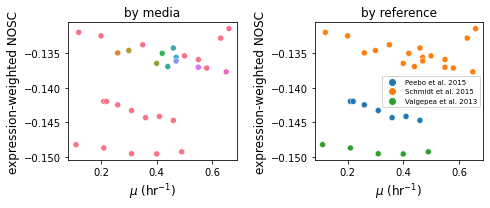

In [6]:
fig, axs = plt.subplots(figsize=(7,3), ncols=2)

for ax, hue in zip(axs, ['media', 'reference']):
    plt.sca(ax)
    sns.scatterplot(data=conds_df, x='growth rate [h-1]', y='Ce_mean', hue=hue, legend=True)
    plt.legend().set_visible(False)
    plt.xlabel('$\mu$ (hr$^{-1}$)', fontsize=12)
    plt.ylabel('expression-weighted NOSC', fontsize=12)
    plt.title('by {0}'.format(hue))
    
plt.legend(fontsize=7)

plt.tight_layout()
plt.savefig('../output/protein_NOSC_Davidi_data.png', facecolor='w', dpi=600)
plt.show()

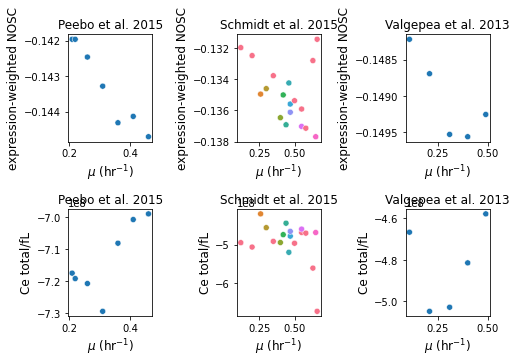

In [7]:
fig, axs = plt.subplots(figsize=(7,5), ncols=3, nrows=2)

for ax, ref in zip(axs[0,:], conds_df.reference.unique()):
    plt.sca(ax)
    sub_df = conds_df[conds_df.reference == ref]
    sns.scatterplot(data=sub_df, x='growth rate [h-1]', y='Ce_mean', hue='media', legend=False)
    plt.xlabel('$\mu$ (hr$^{-1}$)', fontsize=12)
    plt.ylabel('expression-weighted NOSC', fontsize=12)
    plt.title(ref)
    
for ax, ref in zip(axs[1,:], conds_df.reference.unique()):
    plt.sca(ax)
    sub_df = conds_df[conds_df.reference == ref]
    sns.scatterplot(data=sub_df, x='growth rate [h-1]', y='Ce_tot', hue='media', legend=False)
    plt.xlabel('$\mu$ (hr$^{-1}$)', fontsize=12)
    plt.ylabel('Ce total/fL', fontsize=12)
    plt.title(ref)
    
plt.tight_layout()
plt.show()

In [8]:
conds_df

,media,media_key,strain,growth mode,growth rate [h-1],uptake rate [mmol gCDW-1 h-1],growth rate std [h-1],single cell volume [fL],comments,reference,Ce_tot,Ce_mean
growth condition,,,,,,,,,,,,
GLC_CHEM_mu=0.21_P,glucose,glc,BW25113,chemostat,0.21,2.66,0.00,NaN,NaN,Peebo et al. 2015,-7.174671e+08,-0.141965
GLC_CHEM_mu=0.22_P,glucose,glc,BW25113,chemostat,0.22,3.81,0.00,NaN,NaN,Peebo et al. 2015,-7.191623e+08,-0.141964
GLC_CHEM_mu=0.26_P,glucose,glc,BW25113,chemostat,0.26,4.91,0.00,NaN,NaN,Peebo et al. 2015,-7.207153e+08,-0.142465
GLC_CHEM_mu=0.31_P,glucose,glc,BW25113,chemostat,0.31,2.78,0.00,NaN,NaN,Peebo et al. 2015,-7.293952e+08,-0.143286
GLC_CHEM_mu=0.36_P,glucose,glc,BW25113,chemostat,0.36,3.25,0.00,NaN,NaN,Peebo et al. 2015,-7.081209e+08,-0.144316
GLC_CHEM_mu=0.41_P,glucose,glc,BW25113,chemostat,0.41,4.36,0.00,NaN,NaN,Peebo et al. 2015,-7.007320e+08,-0.144137
GLC_CHEM_mu=0.46_P,glucose,glc,BW25113,chemostat,0.46,5.52,0.00,NaN,NaN,Peebo et al. 2015,-6.989597e+08,-0.144710
GLC_CHEM_mu=0.51_P,glucose,glc,BW25113,chemostat,0.51,6.24,0.00,NaN,NaN,Peebo et al. 2015,NaN,NaN
GLC_CHEM_mu=0.12_S,glucose,glc,BW25113,chemostat,0.12,NaN,0.00,1.90,NaN,Schmidt et al. 2015,-4.949045e+08,-0.131981


In [9]:
chure_df = pd.read_csv('../data/Chure_compiled_absolute_measurements.csv', index_col=0)

In [10]:
chure_df.set_index('b_number')

,condition,go_terms,cog_class,cog_category,cog_letter,growth_rate_hr,gene_product,tot_per_cell,fg_per_cell,dataset,dataset_name,strain
b_number,,,,,,,,,,,,
b0259,lb_miller,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,1.90,CP4-6 prophage; IS5 transposase and trans-acti...,263.834345,0.017224,schmidt_2016,Schmidt et al. 2016,BW25113
b0259,glycerol_pAA,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,1.27,CP4-6 prophage; IS5 transposase and trans-acti...,123.587772,0.008068,schmidt_2016,Schmidt et al. 2016,BW25113
b0259,acetate,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.30,CP4-6 prophage; IS5 transposase and trans-acti...,18.492529,0.001207,schmidt_2016,Schmidt et al. 2016,BW25113
b0259,fumarate,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.42,CP4-6 prophage; IS5 transposase and trans-acti...,58.741236,0.003835,schmidt_2016,Schmidt et al. 2016,BW25113
b0259,galactose,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.26,CP4-6 prophage; IS5 transposase and trans-acti...,39.742334,0.002594,schmidt_2016,Schmidt et al. 2016,BW25113
...,...,...,...,...,...,...,...,...,...,...,...,...
b1852,rich,GO:0016614; GO:0005515; GO:0042802; GO:0010699...,metabolism,carbohydrate transport and metabolism,G,0.65,GLU6PDEHYDROG-MONOMER,1074.805447,0.099386,peebo_2015,Peebo et al. 2015,BW25113
b1852,rich,GO:0016614; GO:0005515; GO:0042802; GO:0010699...,metabolism,carbohydrate transport and metabolism,G,0.73,GLU6PDEHYDROG-MONOMER,1079.410764,0.099812,peebo_2015,Peebo et al. 2015,BW25113
b1852,rich,GO:0016614; GO:0005515; GO:0042802; GO:0010699...,metabolism,carbohydrate transport and metabolism,G,0.74,GLU6PDEHYDROG-MONOMER,1197.355432,0.110718,peebo_2015,Peebo et al. 2015,BW25113
